In [1]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MLP(nn.Module):
    def __init__(
        self, hidden_dim=30, hidden_num:int=5
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.hidden_num = hidden_num
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim,10)
        self.max_pool2d = nn.MaxPool2d(2)
        self.dropout = nn.Dropout()
    

    def __call__(self, x):
        x = self.max_pool2d(self.conv1(x))
        x = self.max_pool2d(self.conv2(x))
        x = x.reshape(-1,320)
        x = nn.relu(self.fc1(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = nn.relu(self.fc_hidden(x))
        x = nn.relu(self.fc_out(x))
        return nn.log_softmax(x)
        


In [4]:
num_layers = 10
hidden_dim = 128

# Load the model
model = MLP(hidden_dim=hidden_dim,hidden_num=num_layers)

In [5]:
def load_mnist_dataset(train_data_path:str, 
                       train_label_path:str, 
                       test_data_path:str, 
                       test_label_path:str):
    
    train_images = idx2numpy.convert_from_file(train_data_path)
    train_labels = idx2numpy.convert_from_file(train_label_path)
    test_images = idx2numpy.convert_from_file(test_data_path)
    test_labels = idx2numpy.convert_from_file(test_label_path)
    return (train_images, train_labels, test_images, test_labels)



In [6]:
train_images, train_labels, test_images, test_labels = map(
                                                        np.array, 
                                                        load_mnist_dataset(
                                                            "data/train-images-idx3-ubyte",
                                                            "data/train-labels-idx1-ubyte",
                                                            "data/t10k-images-idx3-ubyte",
                                                            "data/t10k-labels-idx1-ubyte"
                                                        ))
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
train_images = mx.array(train_images,dtype=mx.float32)
train_labels = mx.array(train_labels,dtype=mx.uint8)
test_images = mx.array(test_images,dtype=mx.float32)
test_labels = mx.array(test_labels,dtype=mx.uint8)


In [7]:
print("Train images shape:",train_images.shape)
print("Train labels shape:",train_labels.shape)
print("Test images shape:",test_images.shape)
print("Test labels shape:",test_labels.shape)

Train images shape: (60000, 28, 28, 1)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


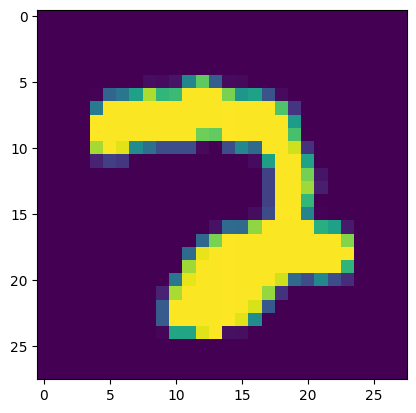

In [8]:
plt.imshow(train_images[120])
plt.show()

In [9]:
model_output = model(mx.array(train_images,dtype=mx.float32))


In [10]:
model_output.shape

(60000, 10)

In [11]:
def eval_fn(model, X, y) -> mx.array:
    return mx.mean(mx.argmax(model(X), axis=1) == y)

In [12]:
def loss_fn(model, X, y) -> mx.array:
    return mx.mean(nn.losses.cross_entropy(model(X), y))


In [13]:
flattened_train_images = train_images.reshape((60000,28*28))
print(flattened_train_images.shape)
flattened_test_images = test_images.reshape((10000,28*28))
print(flattened_test_images.shape)


(60000, 784)
(10000, 784)


In [14]:
# Shuffle in minibatch
def batch_iterate(batch_size, X, y):
    perm = mx.array(np.random.permutation(y.size))
    for s in range(0, y.size, batch_size):
        ids = perm[s : s + batch_size]
        yield X[ids], y[ids]

In [15]:
num_layers = 10
hidden_dim = 128
batch_size = 128
num_epochs = 25
learning_rate = 0.05


mx.eval(model.parameters())

In [16]:
print(model)

MLP(
  (conv1): Conv2d(1, 10, kernel_size=(5,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
  (conv2): Conv2d(10, 20, kernel_size=(5,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
  (fc1): Linear(input_dims=320, output_dims=128, bias=True)
  (fc_hidden): Linear(input_dims=128, output_dims=128, bias=True)
  (fc_out): Linear(input_dims=128, output_dims=10, bias=True)
  (max_pool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (dropout): Dropout(p=0.5)
)


In [17]:
# Get a function which gives the loss and gradient of the
# loss with respect to the model's trainable parameters
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

# Instantiate the optimizer
optimizer = optim.SGD(learning_rate=learning_rate)

In [18]:
train_accuracy = []
for e in range(num_epochs):
    for X, y in batch_iterate(batch_size, train_images, train_labels):
        loss, grads = loss_and_grad_fn(model, X, y)

        # Update the optimizer state and model parameters
        # in a single call
        optimizer.update(model, grads)

        # Force a graph evaluation
        mx.eval(model.parameters(), optimizer.state)

    accuracy = eval_fn(model, test_images, test_labels)
    train_accuracy.append(accuracy.item())
    print(f"Epoch {e}: Test accuracy {accuracy.item():.3f}")

Epoch 0: Test accuracy 0.098
Epoch 1: Test accuracy 0.288
Epoch 2: Test accuracy 0.464
Epoch 3: Test accuracy 0.357
Epoch 4: Test accuracy 0.557
Epoch 5: Test accuracy 0.928
Epoch 6: Test accuracy 0.940
Epoch 7: Test accuracy 0.954
Epoch 8: Test accuracy 0.959
Epoch 9: Test accuracy 0.965
Epoch 10: Test accuracy 0.963
Epoch 11: Test accuracy 0.967
Epoch 12: Test accuracy 0.972
Epoch 13: Test accuracy 0.972
Epoch 14: Test accuracy 0.174
Epoch 15: Test accuracy 0.859
Epoch 16: Test accuracy 0.884
Epoch 17: Test accuracy 0.959
Epoch 18: Test accuracy 0.963
Epoch 19: Test accuracy 0.959
Epoch 20: Test accuracy 0.967
Epoch 21: Test accuracy 0.971
Epoch 22: Test accuracy 0.973
Epoch 23: Test accuracy 0.972
Epoch 24: Test accuracy 0.964


In [19]:
p=mx.expand_dims(test_images[1000],axis=0)
p.shape

(1, 28, 28, 1)

In [20]:
model(p).shape

(1, 10)

In [21]:
mx.argmax(model(p),axis=1)

array([9], dtype=uint32)

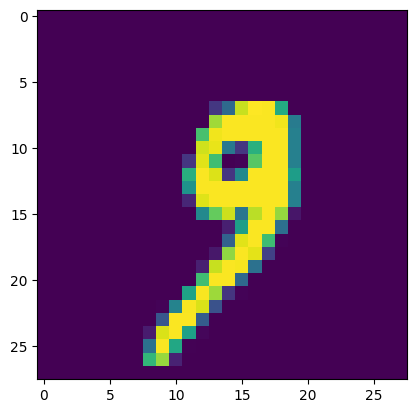

In [22]:
plt.imshow(test_images[1000])
plt.show()

In [23]:
print(1e-1)

0.1
